In [2]:
################################# ----               IT Ticket Classification

######                            ----       Capstone Project      -----------

In [1]:
#########################                   importing the necessary libraries               #############
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
################   --------------         importing tensorflow    -------------------     #############
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.8.2'

In [4]:
# Mounting the google colab drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#######################                                 Load the dataset - reading the data from json                   ###################

### Q.1. Read and explore the data 

In [108]:
ticket_data = pd.read_excel('/content/drive/My Drive/AIML/Projects/Capestone/input_data.xlsx')

In [109]:
ticket_data.rename(columns = {'Short description':'Short_description', 'Description':'Description',
                              'Caller':'Caller','Assignment group':'Assignment_group'}, inplace = True)

In [110]:
### Showing some observation
ticket_data.head(5)

,Short_description,Description,Caller,Assignment_group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,_x000D_\n_x000D_\nreceived from: hmjdrvpb.komu...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,_x000D_\n_x000D_\nreceived from: eylqgodm.ybqk...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [111]:
# observation - 4 columns are there.
# 'Short description'- brief on the issue 
# 'Description'- Details on the issue
# 'Assignment group' - corresponding assignment group

In [112]:
ticket_data.describe()

,Short_description,Description,Caller,Assignment_group
count,8492,8499,8500,8500
unique,7481,7817,2950,74
top,password reset,the,bpctwhsn kzqsbmtp,GRP_0
freq,38,56,810,3976


In [113]:
# overall 8500 observations with 74 individual groups

In [114]:
# Drop the 'Caller' column from the dataset as this does not have suitable information
ticket_data = ticket_data.drop('Caller',axis=1)

In [115]:
ticket_data.shape

(8500, 3)

In [116]:
## To pre-process the text we need to drop null values first

ticket_data = ticket_data.dropna()
ticket_data.shape

(8491, 3)

In [117]:
duplicate = ticket_data[ticket_data.duplicated()]
 
print("Duplicate Rows :")
duplicate

Duplicate Rows :


,Short_description,Description,Assignment_group
51,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty,GRP_0
81,erp SID_34 account locked,erp SID_34 account locked,GRP_0
123,unable to display expense report,unable to display expense report,GRP_0
157,ess password reset,ess password reset,GRP_0
229,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty,GRP_0
...,...,...,...
8424,windows account lockout,windows account lockout,GRP_0
8450,unable to connect to wifi,unable to connect to wifi,GRP_0
8451,password reset erp SID_34,password reset erp SID_34,GRP_0
8458,windows account locked,windows account locked,GRP_0


In [118]:
ticket_data.drop_duplicates(inplace=True)

In [119]:
ticket_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7903 entries, 0 to 8499
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short_description  7903 non-null   object
 1   Description        7903 non-null   object
 2   Assignment_group   7903 non-null   object
dtypes: object(3)
memory usage: 247.0+ KB


In [120]:
# ## Step1 - Preprocess text
#  -- Preprocess values of text & headline column

#  -- Remove unwanted characters
#  -- Convert text to lowercase
#  -- Remove unwanted spaces
#  -- Remove stopwords
#  -- Replace empty strings with Null
#  -- Drop null values from the dataframe

In [121]:
def preprocess_text(df, column_name=''):

  # Select only alphabets
  df[column_name] = df[column_name].apply(lambda x: re.sub('[^A-Za-z]+', ' ', x))

  # Convert text to lowercase
  df[column_name] = df[column_name].apply(lambda x: x.lower())

  # Strip unwanted spaces
  df[column_name] = df[column_name].apply(lambda x: x.strip())

  ## Remove unwanted characters -  Remove punctuation
  df[column_name] = df[column_name].map(lambda x: re.sub('[,\.!?()-;@#$%&^*\|{}:<>/~]', '', x))

  # replace quotes
  df[column_name] = df[column_name].map(lambda x: re.sub('"','',x))

  # remove unwanted space from string 
  df[column_name] = df[column_name].map(lambda x: re.sub(' +', ' ', x))

  # Remove email Ids
  df[column_name] = df[column_name].apply(lambda x: re.sub(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]{2,4}',' ',x))
  
  # Remove label url link
  df[column_name]=df[column_name].apply(lambda x: re.sub(r'urlLink|urllink','',x))
  df[column_name]=df[column_name].apply(lambda x: re.sub(r'https?\S+','',x))
  df[column_name]=df[column_name].apply(lambda x: re.sub(r'www?\S+','',x))
  df[column_name]=df[column_name].apply(lambda x: re.sub(r'link?\S+','',x))

  df[column_name] = df[column_name].apply((lambda x: re.sub(r'([xx]+)|([XX]+)|(\d+)', '',x)))
  df[column_name] = df[column_name].apply((lambda x: re.sub(r'[_D_\n_D_\n]', '',x)))

  # Remove hello
  df[column_name] = df[column_name].apply(lambda x: re.sub(r'hello ', ' ', x))

  # Remove stopwords
  df[column_name] = df[column_name].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

  # Replace empty strings with Null
  df[column_name].replace('', np.nan, inplace = True)

  # Drop Null values
  df = df.dropna()

  return df

In [122]:
ticket_data = preprocess_text(ticket_data, column_name = 'Description')
ticket_data = preprocess_text(ticket_data, column_name = 'Short_description')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [126]:
ticket_data.tail(10)

,Short_description,Description,Assignment_group
8490,check status purchasing,please contact ed pasgryowski pasgryo purchasi...,GRP_29
8491,vpn laptop,received jgobwrm qkugdipo gmail com need vpn n...,GRP_34
8492,hr tool etime option visitble,hr tool etime option visitble,GRP_0
8493,erp fi ob two accounts added,sorry another two accounts need added please c...,GRP_10
8494,tablet needs reimaged due multiple issues crm ...,tablet needs reimaged due multiple issues crm ...,GRP_3
8495,emails coming zz mail,received avglmrts vhqmtiua gmail com good afte...,GRP_29
8496,telephony software issue,telephony software issue,GRP_0
8497,vip windows password reset tifpdchb pedruyf,vip windows password reset tifpdchb pedruyf,GRP_0
8498,machine n est funcionando,unable access machine utilities finish drawers...,GRP_62
8499,mehreren pc lassen sich verschiedene prgramdnt...,mehreren pc lassen sich verschiedene prgramdnt...,GRP_49


In [128]:
ticket_data.tail(10)

,Short_description,Description,Assignment_group
8490,check status purchasing,please contact ed pasgryowski pasgryo purchasi...,GRP_29
8491,vpn laptop,received jgobwrm qkugdipo gmail com need vpn n...,GRP_34
8492,hr tool etime option visitble,hr tool etime option visitble,GRP_0
8493,erp fi ob two accounts added,sorry another two accounts need added please c...,GRP_10
8494,tablet needs reimaged due multiple issues crm ...,tablet needs reimaged due multiple issues crm ...,GRP_3
8495,emails coming zz mail,received avglmrts vhqmtiua gmail com good afte...,GRP_29
8496,telephony software issue,telephony software issue,GRP_0
8497,vip windows password reset tifpdchb pedruyf,vip windows password reset tifpdchb pedruyf,GRP_0
8498,machine n est funcionando,unable access machine utilities finish drawers...,GRP_62
8499,mehreren pc lassen sich verschiedene prgramdnt...,mehreren pc lassen sich verschiedene prgramdnt...,GRP_49


In [129]:
###### Step 3 - Another built in function to pre-process the text with stemming, lemmitization and others

import nltk
# nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
  sentence=str(sentence)
  # sentence = sentence.lower()
  sentence = sentence.replace('{html}',"") 
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', sentence)
  rem_url = re.sub(r'http\S+', '',cleantext)
  rem_num = re.sub('[0-9]+', '', rem_url)
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(rem_num)  
  # filtered_words = [w for w in tokens if len(w) >= 2 if not w in stopwords.words('english')]
  stem_words = [stemmer.stem(w) for w in tokens]
  lemma_words = [lemmatizer.lemmatize(w) for w in stem_words]
  return " ".join(lemma_words)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [130]:
ticket_data['Description'] = ticket_data['Description'].map(lambda s:preprocess(s))

In [131]:
ticket_data.head(10)

,Short_description,Description,Assignment_group
0,login issue,verifi user detail employe manag name check us...,GRP_0
1,outlook,receiv hmjdrvpb komuaywn gmail com team meet s...,GRP_0
2,cant log vpn,receiv eylqgodm ybqkwiam gmail com hi cannot l...,GRP_0
3,unable access hr tool page,unabl access hr tool page,GRP_0
4,skype error,skype error,GRP_0
5,unable log engineering tool skype,unabl log engin tool skype,GRP_0
6,event critical hostname company com value moun...,event critic hostnam compani com valu mountpoi...,GRP_1
7,ticket employment status new non employee ente...,ticket employ statu new non employe enter user...,GRP_0
8,unable disable add ins outlook,unabl disabl add in outlook,GRP_0
9,ticket update inplant,ticket updat inplant,GRP_0


In [132]:
ticket_data.shape

(7806, 3)

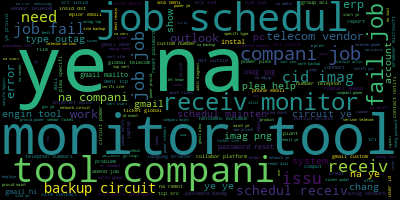

In [135]:
##########################                 Word Cloud                    ############
import wordcloud
long_string = " ".join(ticket_data['Description'])
wordcloud = wordcloud.WordCloud()
wordcloud.generate(long_string)
wordcloud.to_image()

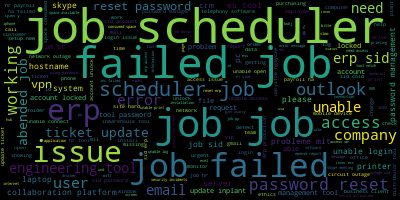

In [136]:
### Additional testing with word cloud
import wordcloud
long_string = " ".join(ticket_data['Short_description'])
wordcloud = wordcloud.WordCloud()
wordcloud.generate(long_string)
wordcloud.to_image()

In [137]:
### Target Variable Frequency

In [166]:
target_count = ticket_data["Assignment_group"].value_counts().reset_index()
target_count = pd.DataFrame(target_count)
target_count.rename(columns = {'index':'Assignment_group', 'Assignment_group':'Count'}, inplace = True)

In [177]:
target_count.head(10)

,Assignment_group,Count
0,GRP_0,3418
1,GRP_8,645
2,GRP_24,285
3,GRP_12,256
4,GRP_9,252
5,GRP_2,241
6,GRP_19,214
7,GRP_3,200
8,GRP_6,183
9,GRP_13,144


In [168]:
### Lot of "Assignment_group" observed to have very few Counts
## Remove groups with counts less than 10 observation

ticket_data = pd.merge(ticket_data,target_count,how='left',left_on='Assignment_group',right_on='Assignment_group')

In [178]:
ticket_data = ticket_data[ticket_data.Count > 10]
ticket_data['Assignment_group'].describe()

count      7713
unique       48
top       GRP_0
freq       3418
Name: Assignment_group, dtype: object

In [181]:
### Group_0 represents around 44% of the population with overall around 48 major categories

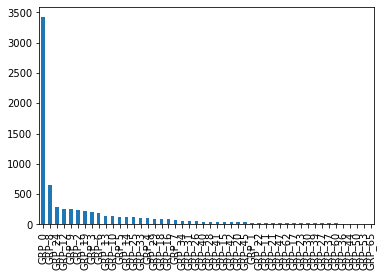

In [180]:
import matplotlib.pyplot as plt
import pandas

fig, ax = plt.subplots()
ticket_data["Assignment_group"].value_counts().plot(ax=ax, kind='bar')

In [183]:
###################                           Need to continue work from here           #######################

In [182]:
## Add START and END token at the beginning and end of the headline

headline_data['headline_processed'] = headline_data['headline_processed'].apply(lambda x : 'sostok '+ x + ' eostok')

NameError: ignored

In [ ]:
## Q.3. Get length of each sentence and add a new length column to the dataframe

headline_data['len_headline'] = headline_data['headline_processed'].apply(lambda x: len(x.split(" ")))
headline_data.head()

,headline,is_sarcastic,headline_processed,len_headline
0,former versace store clerk sues secret black c...,0,sostok former versac store clerk sue secret bl...,12
1,roseanne revival catches thorny political mood...,0,sostok roseann reviv catch thorni polit mood b...,10
2,mom starting fear son web series closest thing...,1,sostok mom start fear son web seri closest thi...,11
3,boehner wants wife listen come alternative deb...,1,sostok boehner want wife listen come altern de...,11
4,j k rowling wishes snape happy birthday magica...,0,sostok j k rowl wish snape happi birthday magi...,11


In [ ]:
### Check the distribution of data
###    --- This will help us in deciding maxlen

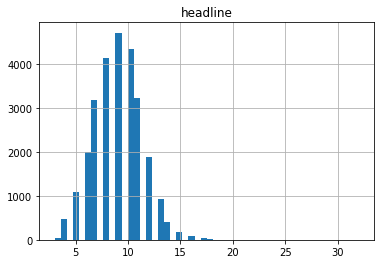

In [ ]:
import matplotlib.pyplot as plt
headline_word_count = []

# populate the lists with sentence lengths

for i in headline_data['headline_processed']:
  headline_word_count.append(len(i.split()))

length_df = pd.DataFrame({'headline':headline_word_count})
length_df.hist(bins = 50)
plt.show()

In [ ]:
### Let's check the percentage of heading below 15 words

In [ ]:
cnt=0
for i in headline_data['headline_processed']:
    if(len(i.split())<=15):
        cnt=cnt+1
print(cnt/len(headline_data['headline_processed']))

0.994982588834388


In [ ]:
# observation - 99.5% headlines has text upto length 15

In [ ]:
# For reducing data, we'll take headings where length <15

headline_data = headline_data[(headline_data.len_headline <= 15)]

In [ ]:
headline_data.head()

,headline,is_sarcastic,headline_processed,len_headline
0,former versace store clerk sues secret black c...,0,sostok former versac store clerk sue secret bl...,12
1,roseanne revival catches thorny political mood...,0,sostok roseann reviv catch thorni polit mood b...,10
2,mom starting fear son web series closest thing...,1,sostok mom start fear son web seri closest thi...,11
3,boehner wants wife listen come alternative deb...,1,sostok boehner want wife listen come altern de...,11
4,j k rowling wishes snape happy birthday magica...,0,sostok j k rowl wish snape happi birthday magi...,11


In [ ]:
headline_data.groupby(['is_sarcastic'])['is_sarcastic'].count()/len(headline_data)

is_sarcastic
0    0.562676
1    0.437324
Name: is_sarcastic, dtype: float64

In [ ]:
### Train test split of the development sample

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(headline_data.headline_processed, headline_data.is_sarcastic, test_size = 0.3, random_state=42)

In [ ]:
# Q.4. -- Apply tensorflow.keras Tokenizer and get indices for words

# Initialize Tokenizer object with number of words as 10000
# Fit different tokenizer objects on headline and text column
# Convert the text to sequence

In [ ]:
max_features = 10000
# maxlen_headline = 15
maxlen_text = 15

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

feature_tokenizer = Tokenizer(num_words=max_features)
feature_tokenizer.fit_on_texts(X_train)
X_train = feature_tokenizer.texts_to_sequences(X_train)
X_test = feature_tokenizer.texts_to_sequences(X_test)

print("Number of Samples in X_train:", len(X_train))       
print(X_train[0])

Number of Samples in X_train: 18601
[1, 276, 580, 319, 1440, 887, 669, 1992, 1523, 22, 1782, 2]


In [ ]:
feature_tokenizer.word_index

{'sostok': 1,
 'eostok': 2,
 'trump': 3,
 'new': 4,
 'man': 5,
 'woman': 6,
 'get': 7,
 'year': 8,
 'report': 9,
 'make': 10,
 'say': 11,
 'u': 12,
 'one': 13,
 'day': 14,
 'american': 15,
 'nation': 16,
 'time': 17,
 'donald': 18,
 'area': 19,
 'like': 20,
 'first': 21,
 'obama': 22,
 'take': 23,
 'way': 24,
 'peopl': 25,
 'hous': 26,
 'old': 27,
 'world': 28,
 'thing': 29,
 'find': 30,
 'life': 31,
 'clinton': 32,
 'show': 33,
 'go': 34,
 'white': 35,
 'want': 36,
 'call': 37,
 'back': 38,
 'look': 39,
 'still': 40,
 'famili': 41,
 'child': 42,
 'use': 43,
 'right': 44,
 'live': 45,
 'love': 46,
 'school': 47,
 'know': 48,
 'work': 49,
 'state': 50,
 'need': 51,
 'watch': 52,
 'could': 53,
 'black': 54,
 'chang': 55,
 'plan': 56,
 'mom': 57,
 'bill': 58,
 'presid': 59,
 'come': 60,
 'kill': 61,
 'gop': 62,
 'think': 63,
 'kid': 64,
 'give': 65,
 'would': 66,
 'last': 67,
 'polic': 68,
 'studi': 69,
 'talk': 70,
 'home': 71,
 'good': 72,
 'parent': 73,
 'death': 74,
 'video': 75,
 'am

In [ ]:
#####     Q.5 ----- Pad Pad each example with a maximum length and convert target column into numpy array  

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen = maxlen_text, padding='post')
X_test = pad_sequences(X_test, maxlen = maxlen_text, padding='post')

In [ ]:
X_train[15]

array([   1,  856,  402, 4265, 2611, 1443,  569, 3740,  409,  792,    2,
          0,    0,    0,    0], dtype=int32)

In [ ]:
## observation - pad examples upto length 15

In [ ]:
# convert target column into numpy array  
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
### Set number of words
# - Since the above 0th index doesn't have a word, add 1 to the length of the vocabulary

In [ ]:
num_words_text = len(feature_tokenizer.word_index) + 1
print(num_words_text)

14464


In [ ]:
## Delete rows that contain only START and END token

In [ ]:
ind=[]
for i in range(len(X_train)):
    cnt=0
    for j in X_train[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

X_train=np.delete(X_train,ind, axis=0)
y_train=np.delete(y_train,ind, axis=0)

ind=[]
for i in range(len(X_test)):
    cnt=0
    for j in X_test[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)
X_test=np.delete(X_test,ind, axis=0)
y_test=np.delete(y_test,ind, axis=0)

In [ ]:
y_train

array([1, 0, 0, ..., 0, 1, 0])

In [ ]:
########     --------- Q.6 Define and compile a Bidirectional LSTM model    ---------------    ######

In [ ]:
!git clone "https://github.com/thushv89/attention_keras"

fatal: destination path 'attention_keras' already exists and is not an empty directory.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Concatenate, Bidirectional, Input, Flatten
from attention_keras.src.layers.attention import AttentionLayer

input = Input(shape=(maxlen_text,)) # Input layer
model = Embedding(input_dim = num_words_text, output_dim=50, input_length=maxlen_text)(input) # Word embedding layer
model = Dropout(0.1)(model) # Dropout
model = Bidirectional(LSTM(units=100, return_sequences= True, recurrent_dropout=0.1))(model) # Bi-directional LSTM layer
model = TimeDistributed(Dense(100, activation="relu"))(model)  # softmax output layer
model = Flatten()(model) # Flatten layer
output = Dense(1,activation='sigmoid')(model) # output layer

In [ ]:
model = Model(input,output)
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) # cross entropy is the loss function considered

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
X_train.shape

(18599, 15)

In [ ]:
history = model.fit(X_train, y_train, batch_size=100, epochs=10, validation_split=0.25, verbose=1) # Train the model

Epoch 1/10
140/140 [==============================] - 72s 116ms/step - loss: 0.5599 - accuracy: 0.6963 - val_loss: 0.4603 - val_accuracy: 0.7867
Epoch 2/10
140/140 [==============================] - 16s 112ms/step - loss: 0.3512 - accuracy: 0.8493 - val_loss: 0.4615 - val_accuracy: 0.7931
Epoch 3/10
140/140 [==============================] - 16s 112ms/step - loss: 0.2547 - accuracy: 0.8949 - val_loss: 0.4988 - val_accuracy: 0.7869
Epoch 4/10
140/140 [==============================] - 16s 111ms/step - loss: 0.1864 - accuracy: 0.9269 - val_loss: 0.5608 - val_accuracy: 0.7858
Epoch 5/10
140/140 [==============================] - 16s 112ms/step - loss: 0.1350 - accuracy: 0.9490 - val_loss: 0.7068 - val_accuracy: 0.7705
Epoch 6/10
140/140 [==============================] - 16s 113ms/step - loss: 0.0984 - accuracy: 0.9637 - val_loss: 0.8810 - val_accuracy: 0.7751
Epoch 7/10
140/140 [==============================] - 16s 113ms/step - loss: 0.0770 - accuracy: 0.9718 - val_loss: 0.9329 - val_ac

In [ ]:
### Total 10 iterations has conducted with batch size 100. train and validation accuracy is reported 

In [ ]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 15)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 15, 50)            723200    
                                                                 
 dropout_6 (Dropout)         (None, 15, 50)            0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 15, 200)          120800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 15, 100)          20100     
 tributed)                                                       
                                                                 
 flatten_3 (Flatten)         (None, 1500)              0   

In [ ]:
### model 6 is the best performing model. Total parameter used 865,601.

In [ ]:
# Q.7 - Fit the model and check the validation accuracy

loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print('Accuracy: %f' % (accuracy*100))

249/249 - 3s - loss: 1.4738 - accuracy: 0.7650 - 3s/epoch - 13ms/step
Accuracy: 76.497173


In [ ]:
### 76.7% validation accuracy is observed

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred_class = y_pred > 0.5
cm = confusion_matrix(y_test, y_pred_class)
tn, fp, fn, tp = cm.ravel()

In [ ]:
tn,fp,fn,tp

(3654, 816, 1056, 2439)

In [ ]:
##### Confusion matrix
cm

array([[3654,  816],
       [1056, 2439]])

In [ ]:
print(classification_report(y_test,y_pred_class))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      4470
           1       0.75      0.70      0.72      3495

    accuracy                           0.76      7965
   macro avg       0.76      0.76      0.76      7965
weighted avg       0.76      0.76      0.76      7965



In [ ]:
##### precision observed - 75% , Recall observd - 70%

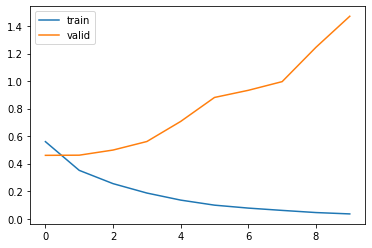

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='valid')
pyplot.legend()
pyplot.show()

In [ ]:
# observation -- 1) the training loss decreased with each iterations. However, the  validation loss increased post 3rd iteration. 
                    # over-fitting is observed in the model training
#                2) The model could be improved further with hyper-parameter tuning
#                3) Overall model performance is satidfactory as the test data accurcay is around 77% with 75% precision of level "1" and 70% recall.

In [ ]:
######### Saving the html file

In [ ]:
!jupyter nbconvert --to html NLP_Assignmnet_Week7_Sarcasm_Detection.ipynb

[NbConvertApp] Converting notebook NLP_Assignmnet_Week7_Sarcasm_Detection.ipynb to html
[NbConvertApp] Writing 848482 bytes to NLP_Assignmnet_Week7_Sarcasm_Detection.html
